In [ ]:
!pip install transformers diffusers lpips accelerate
!pip install torch torchvision
!pip install diffusers[torch]
!pip install tqdm pillow matplotlib ipython numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import os
import gc
import torch
from torch import autocast
from torchvision import transforms as tfms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.models.attention import BasicTransformerBlock
import torch.nn.utils.prune as prune
from accelerate import cpu_offload_with_hook
from lpips import LPIPS
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from transformers.utils import logging
logging.set_verbosity_info()


In [3]:
use_amp = torch.cuda.is_available()
if use_amp:
    print("AMP enabled.")

AMP enabled.


In [4]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {torch_device}")

from transformers.utils import logging
logging.set_verbosity_info()

Using device: cuda


In [5]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/tokenizer.json
loading file chat_template.jinja from cache at None
ft

config.json: 0.00B [00:00, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/config.json
Model config CLIPTextConfig {
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "dropout": 0.0,
  "eos_token_id": 2,
  "hidden_act": "quick_gelu",
  "hidden_size": 768,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 77,
  "model_type": "clip_text_model",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "projection_dim": 768,
  "transformers_version": "4.53.0",
  "vocab_size": 49408
}



model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41/model.safetensors
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['logit_scale', 'text_projection.weight', 'vision_model.embeddings.class_embedding', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.enco

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
unet.enable_gradient_checkpointing()

In [7]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [8]:
if torch_device == "cpu":
    cpu_offload_with_hook(vae, execution_device=torch.device("cpu"))

In [9]:
def prune_unet_attention(unet_model):
    for name, module in unet_model.named_modules():
        if isinstance(module, BasicTransformerBlock):
            for param_name, _ in module.named_parameters():
                try:
                    prune.random_unstructured(module, name=param_name, amount=0.2)
                except:
                    pass

prune_unet_attention(unet)

# Optional attention map hook
attention_maps = []
def save_attention_hook(module, input, output):
    if hasattr(output, 'attn_probs'):
        attention_maps.append(output.attn_probs.detach().cpu())

for name, module in unet.named_modules():
    if isinstance(module, BasicTransformerBlock):
        module.register_forward_hook(save_attention_hook)
        print(f"Hooked attention at layer: {name}")
        break


Hooked attention at layer: down_blocks.0.attentions.0.transformer_blocks.0


In [37]:
prompt = [
    "A post-apocalyptic cityscape with crumbling, dilapidated skyscrapers overtaken by nature. "
    "Vines and massive trees grow through shattered windows and collapsed roofs. The streets are cracked, "
    "filled with roots and overgrowth. No signs of humans, just nature reclaiming the ruins. Moody lighting, "
    "overcast skies, high detail, ultra-realistic, cinematic, 4K, concept art style."
]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(4)
batch_size = 1

# High-resolution mode
if height > 512 or width > 768:
    print("High-res mode activated.")
    num_inference_steps = int(num_inference_steps * 1.5)

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [38]:
scheduler.set_timesteps(num_inference_steps)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(torch_device)
latents = latents * scheduler.sigmas[0]

/tmp/ipython-input-38-3208537054.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator).to(torch_device)


In [39]:
autocast_context = autocast("cuda") if use_amp else torch.no_grad()
with autocast_context:
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[(scheduler.timesteps == t).nonzero(as_tuple=True)[0].item()]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:468: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:468: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


In [40]:
 tile_size=32
 def tile_latents(latents):
    _, c, h, w = latents.shape
    if h % tile_size != 0 or w % tile_size != 0:
         raise ValueError(f"Latent size ({h}, {w}) not divisible by tile size {tile_size}")
    tiles = []
    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tiles.append(latents[:, :, i:i+tile_size, j:j+tile_size])
    return tiles

tiles = tile_latents(latents)
print(f"Tiled into {len(tiles)} latent chunks with tile size {tile_size}")

Tiled into 6 latent chunks with tile size 32


In [41]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    decoded_output = vae.decode(latents)

image_tensor = decoded_output.sample  # may need to update depending on your model
image = (image_tensor / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(img) for img in images]

In [42]:
lpips_fn = LPIPS(net='vgg')
def calc_lpips(image1, image2):
    tensor1 = tfms.ToTensor()(image1).unsqueeze(0)
    tensor2 = tfms.ToTensor()(image2).unsqueeze(0)
    return lpips_fn(tensor1, tensor2).item()

lpips_score = calc_lpips(pil_images[0], pil_images[0])
print("LPIPS score (identity):", lpips_score)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS score (identity): 0.0



[Memory] Allocated: 4.31 GB
[Memory] Reserved : 4.39 GB


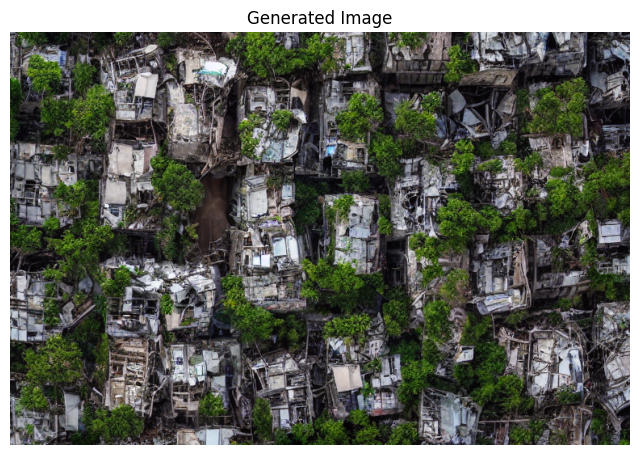

In [44]:
def print_memory_stats():
    if torch.cuda.is_available():
        print(f"\n[Memory] Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"[Memory] Reserved : {torch.cuda.memory_reserved() / 1e9:.2f} GB")

print_memory_stats()
gc.collect()
torch.cuda.empty_cache()

# Show Image
plt.figure(figsize=(8, 6))
plt.imshow(pil_images[0])
plt.axis("off")
plt.title("Generated Image")
plt.show()